# Решающие деревья и случайный лес

In [65]:
import numpy as np
import pandas as pd
import sklearn
import sklearn.model_selection
import sklearn.tree
import sklearn.neighbors
import sklearn.metrics
import sklearn.datasets

## Решающие деревья

![fitting-accuracy](https://bitbucket.org/despairr/ds-course-2018/raw/dbbafa803be8b1f01cc078ba3ba96d176b220669/intro-to-ml-images/324.png)

Зачастую дерево решений служит обобщением опыта экспертов, средством передачи знаний будущим сотрудникам или моделью бизнес-процесса компании. Например, до внедрения масштабируемых алгоритмов машинного обучения в банковской сфере задача кредитного скоринга решалась экспертами. Решение о выдаче кредита заемщику принималось на основе некоторых интуитивно (или по опыту) выведенных правил, которые можно представить в виде дерева решений.
<img src="https://habrastorage.org/files/194/9b6/ae9/1949b6ae97ab4fc9b1a37fbf182eda8f.gif"/><br>
В этом случае можно сказать, что решается задача бинарной классификации (целевой класс имеет два значения: "Выдать кредит" и "Отказать") по признакам "Возраст", "Наличие дома", "Доход" и "Образование".

Дерево решений как алгоритм машинного обучения – по сути то же самое: объединение логических правил вида "Значение признака $a$ меньше $x$ И Значение признака $b$ меньше $y$ ... => Класс 1" в структуру данных "Дерево". Огромное преимущество деревьев решений в том, что они легко интерпретируемы, понятны человеку. Например, по схеме на рисунке выше можно объяснить заемщику, почему ему было отказано в кредите. Скажем, потому, что у него нет дома и доход меньше 5000. Как мы увидим дальше, многие другие, хоть и более точные, модели не обладают этим свойством и могут рассматриваться скорее как "черный ящик", в который загрузили данные и получили ответ. В связи с этой "понятностью" деревьев решений и их сходством с моделью принятия решений человеком (можно легко объяснять боссу свою модель), деревья решений получили огромную популярность, а один из представителей этой группы методов классификации, С4.5, рассматривается первым в списке 10 лучших алгоритмов интеллектуального анализа данных.

### Как строится дерево решений

В примере с кредитным скорингом мы видели, что решение о выдаче кредита принималось на основе возраста, наличия недвижимости, дохода и других. Но какой признак выбрать первым? Для этого рассмотрим пример попроще, где все признаки бинарные.

Здесь можно вспомнить игру "20 вопросов" (например, реализация от Akinator: https://ru.akinator.com/). Один человек загадывает знаменитость, а второй пытается отгадать, задавая только вопросы, на которые можно ответить "Да" или "Нет" (опустим варианты "не знаю" и "не могу сказать"). Какой вопрос отгадывающий задаст первым делом? Конечно, такой, который сильнее всего уменьшит количество оставшихся вариантов. К примеру, вопрос "Это Анджелина Джоли?" в случае отрицательного ответа оставит более 6 миллиардов вариантов для дальнейшего перебора (конечно, поменьше, не каждый человек – знаменитость, но все равно немало), а вот вопрос "Это женщина?" отсечет уже около половины знаменитостей. То есть, признак "пол" намного лучше разделяет выборку людей, чем признак "это Анджелина Джоли", "национальность-испанец" или "любит футбол". Это интуитивно соответствует понятию *прироста информации*, основанного на *энтропии*.

#### Энтропия
Энтропия Шеннона определяется для системы с $N$ возможными состояниями следующим образом:

$$ \Large S = -\sum_{i=1}^{N}p_ilog_2p_i, $$

где  $p_i$ – вероятности нахождения системы в $i$-ом состоянии.
Это очень важное понятие, используемое в физике, теории информации и других областях.
Интуитивно, энтропия соответствует степени хаоса в системе.
Чем выше энтропия, тем менее упорядочена система и наоборот.
Это поможет там формализовать "эффективное разделение выборки", про которое мы говорили в контексте игры "20 вопросов".

<h4>Пример</h4>
Для иллюстрации того, как энтропия поможет определить хорошие признаки для построения дерева, приведем игрушечный пример. Будем предсказывать цвет шарика по его координате. Конечно, ничего общего с жизнью это не имеет, но позволяет показать, как энтропия используется для построения дерева решений.
<img src="https://habrastorage.org/files/c96/80a/a4b/c9680aa4babc40f4bbc8b3595e203979.png"/><br>

Здесь 9 синих шариков и 11 желтых. Если мы наудачу вытащили шарик, то он с вероятностью   $p_1=\frac{9}{20}$ будет синим и с вероятностью  $p_2=\frac{11}{20}$ – желтым. Значит, энтропия состояния  $S_0 = -\frac{9}{20}log_2{\frac{9}{20}}-\frac{11}{20}log_2{\frac{11}{20}} \approx 1$. Само это значение пока ни о чем нам не говорит. Теперь посмотрим, как изменится энтропия, если разбить шарики на две группы – с координатой меньше либо равной 12 и больше 12.
<img src="https://habrastorage.org/files/186/444/a8b/186444a8bd0e451c8324ca8529f8d4f4.png"/><br>

В левой группе оказалось 13 шаров, из которых 8 синих и 5 желтых.
Энтропия этой группы равна $S_1 = -\frac{5}{13}log_2{\frac{5}{13}}-\frac{8}{13}log_2{\frac{8}{13}} \approx 0.96$.
В правой группе оказалось 7 шаров, из которых 1 синий и 6 желтых.
Энтропия правой группы равна $S_2 = -\frac{1}{7}log_2{\frac{1}{7}}-\frac{6}{7}log_2{\frac{6}{7}} \approx 0.6$.
Как видим, энтропия уменьшилась в обеих группах по сравнению с начальным состоянием, хоть в левой и не сильно.
Поскольку энтропия — по сути степень хаоса (или неопределенности) в системе, уменьшение энтропии называют приростом информации.
Формально *прирост информации* (*information gain*, *IG*)
при разбиении выборки по признаку $Q$ (в нашем примере это признак "$x \leq 12$") определяется как 
$$ \Large IG(Q) = S_O - \sum_{i=1}^{q}\frac{|N_i|}{N}S_i, $$
где $q$ – число групп после разбиения, $N_i$ – число элементов выборки, у которых признак $Q$ имеет $i$-ое значение.
В нашем случае после разделения получилось две группы ($q = 2$) – одна из 13 элементов ($N_1 = 13$),
вторая – из 7 ($N_2 = 7$). Прирост информации получился 
$$ \Large IG(x \leq 12) = S_0 - \frac{13}{20}S_1 - \frac{7}{20}S_2 \approx 0.16. $$
Получается, разделив шарики на две группы по признаку "координата меньше либо равна 12",
мы уже получили более упорядоченную систему, чем в начале.
Продолжим деление шариков на группы до тех пор, пока в каждой группе шарики не будут одного цвета.
<img src="https://habrastorage.org/files/dae/a88/2b0/daea882b0a8e4ef4b23325c88f0353a1.png"/><br>
Для правой группы потребовалось всего одно дополнительное разбиение по признаку "координата меньше либо равна 18",
для левой – еще три. Очевидно, энтропия группы с шариками одного цвета равна 0 ($log_2{1} = 0$),
что соответствует представлению, что группа шариков одного цвета – упорядоченная. 
В итоге мы построили дерево решений, предсказывающее цвет шарика по его координате.
Отметим, что такое дерево решений может плохо работать для новых объектов (определения цвета новых шариков),
поскольку оно идеально подстроилось под обучающую выборку (изначальные 20 шариков).
Для классификации новых шариков лучше подойдет дерево с меньшим числом "вопросов", или разделений,
пусть даже оно и не идеально разбивает по цветам обучающую выборку.
Проблему *переобучения* мы еще рассмотрим далее.

#### Алгоритм построения дерева

В основе популярных алгоритмов построения дерева решений, таких как ID3 и C4.5, лежит принцип жадной максимизации прироста информации – на каждом шаге выбирается тот признак, при разделении по которому прирост информации оказывается наибольшим. Дальше процедура повторяется рекурсивно, пока энтропия не окажется равной нулю или какой-то малой величине (если дерево не подгоняется идеально под обучающую выборку во избежание переобучения).
В разных алгоритмах применяются разные эвристики для "ранней остановки" или "отсечения", чтобы избежать построения переобученного дерева.

#### Другие критерии качества разбиения в задаче классификации

Мы разобрались, в том, как понятие энтропии позволяет формализовать представление о качестве разбиения в дереве. Но это всего-лишь эвристика, существуют и другие, например:

- Неопределенность Джини (Gini impurity):  $G = 1 - \sum\limits_k (p_k)^2$. Максимизацию этого критерия можно интерпретировать как максимизацию числа пар объектов одного класса, оказавшихся в одном поддереве. Подробнее об этом (как и обо многом другом) можно узнать из [репозитория](https://github.com/esokolov/ml-course-msu) Евгения Соколова. 

На практике неопределенность Джини и прирост информации работают почти одинаково.

#### Пример

Рассмотрим пример применения дерева решений из библиотеки Scikit-learn для синтетических данных. Сгенерируем данные. Два класса будут сгенерированы из двух нормальных распределений с разными средними.

In [7]:
# Сгенерируем данные

# первый класс
np.random.seed(7)
train_data = np.random.normal(size=(100, 2))
train_labels = np.zeros(100)

# добавляем второй класс
train_data = np.r_[ train_data, np.random.normal( size=(100, 2), loc=[2,2] ) ]
train_labels = np.r_[ train_labels, np.ones(100) ]

Populating the interactive namespace from numpy and matplotlib


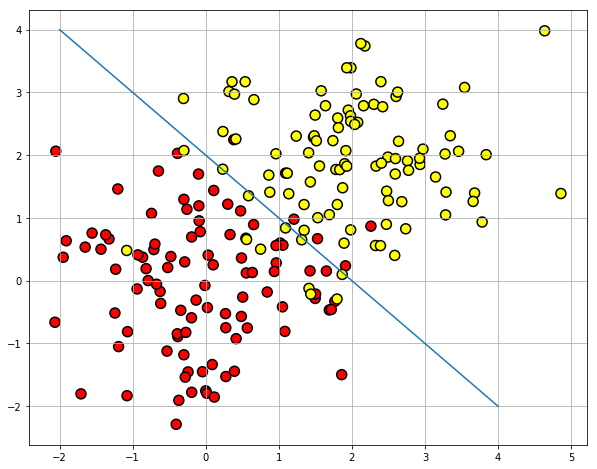

In [9]:
# Отобразим данные
%pylab inline
plt.rcParams['figure.figsize'] = (10,8)
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
            cmap='autumn', edgecolors='black', linewidth=1.5)
plt.plot(range(-2,5), range(4,-3,-1))
plt.grid()

Попробуем разделить эти два класса, обучив дерево решений. В дереве будем использовать параметр `max_depth`, ограничивающий глубину дерева. Визуализируем полученную границу разделения класссов.

In [26]:
# Вспомогательная функция, которая будет возвращать решетку для дальнейшей красивой визуализации
def get_grid(data, eps=0.01):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid( np.arange(x_min, x_max, eps), np.arange(y_min, y_max, eps) )

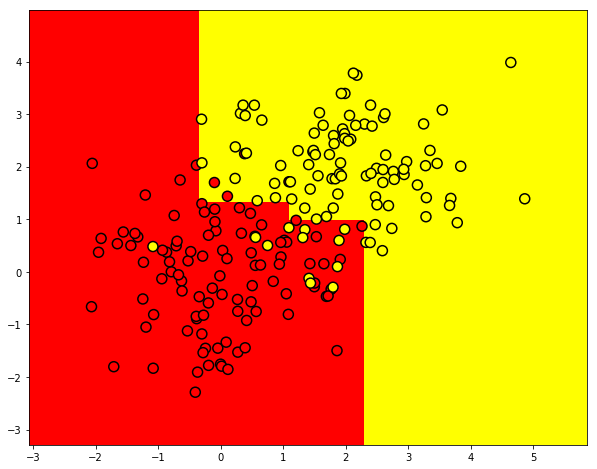

In [27]:
# Создаём объект модели
# параметр min_samples_leaf указывает, при каком минимальном количестве
# элементов в узле он будет дальше разделяться
clf_tree = sklearn.tree.DecisionTreeClassifier(
    criterion = 'entropy', max_depth = 3, random_state = 17
)

# обучаем дерево
clf_tree.fit( train_data, train_labels )

# немного кода для отображения разделяющей поверхности
xx, yy = get_grid( train_data )
predicted = clf_tree.predict( np.c_[xx.ravel(), yy.ravel()] ).reshape( xx.shape )
plt.pcolormesh( xx, yy, predicted, cmap = 'autumn' )
plt.scatter( train_data[:, 0], train_data[:, 1], c=train_labels, s = 100, 
             cmap = 'autumn', edgecolors = 'black', linewidth = 1.5 )

А как выглядит само построенное дерево? Видим, что дерево "нарезает" пространство на 7 прямоугольников (в дереве 7 листьев). В каждом таком прямоугольнике прогноз дерева будет константным, по превалированию объектов того или иного класса.

In [14]:
# используем .dot формат для визуализации дерева
sklearn.tree.export_graphviz(
    clf_tree,
    feature_names = ['x1', 'x2'],
    out_file = '/tmp/small_tree.dot',
    filled = True 
)

# для выполнения следующей команды нужен установленный GraphViz
!dot -Tpng /tmp/small_tree.dot -o /tmp/small_tree.png

![small_tree](https://raw.githubusercontent.com/Yorko/mlcourse.ai/4ea0a5dd3d242aac2ac23040a28194964db50f0d/img/small_tree.png)

Как "читается" такое дерево?

В начале было 200 объектов, 100 – одного класса и 100 – другого. Энтропия начального состояния была максимальной – 1. Затем было сделано разбиение объектов на 2 группы в зависимости от сравнения признака $x_1$ со значением $1.1034$ (найдите этот участок границы на рисунке выше, до дерева). При этом энтропия и в левой, и в правой группе объектов уменьшилась. И так далее, дерево строится до глубины 3. При такой визуализации чем больше объектов одного класса, тем  цвет вершины ближе к темно-оранжевому и, наоборот, чем больше объектов второго класса, тем ближе цвет к темно-синему. В начале объектов одного лкасса поровну, поэтому корневая вершина дерева – белого цвета.

### Как дерево решений работает с количественными признаками

Допустим, в выборке имеется количественный признак "Возраст", имеющий много уникальных значений. Дерево решений будет искать лучшее (по критерию типа прироста информации) разбиение выборки, проверяя бинарные признаки типа "Возраст < 17", "Возраст < 22.87" и т.д. Но что если таких "нарезаний" возраста слишком много? А что если есть еще количественный признак "Зарплата", и зарплату тоже можно "нарезать" большим числом способов? Получается слишком много бинарных признаков для выбора лучшего на каждом шаге построения дерева. Для решения этой проблемы применяют эвристики для ограничения числа порогов, с которыми мы сравниваем количественный признак. 

Рассмотрим это на игрушечном примере. Пусть есть следующая выборка:

In [15]:
data = pd.DataFrame({'Возраст': [17,64,18,20,38,49,55,25,29,31,33], 
             'Невозврат кредита': [1,0,1,0,1,0,0,1,1,0,1]})

data

,Возраст,Невозврат кредита
0,17,1
1,64,0
2,18,1
3,20,0
4,38,1
5,49,0
6,55,0
7,25,1
8,29,1
9,31,0


In [16]:
# Отсортируем ее по возрастанию возраста.
data.sort_values('Возраст')

,Возраст,Невозврат кредита
0,17,1
2,18,1
3,20,0
7,25,1
8,29,1
9,31,0
10,33,1
4,38,1
5,49,0
6,55,0


In [18]:
# Обучим на этих данных дерево решений (без ограничения глубины) и посмотрим на него.

age_tree = sklearn.tree.DecisionTreeClassifier( random_state = 17 )
age_tree.fit( data['Возраст'].values.reshape(-1, 1), data['Невозврат кредита'].values )

# Отрисуем дерево
sklearn.tree.export_graphviz(
    age_tree, feature_names=['Возраст'], 
    out_file = '/tmp/age_tree.dot', filled = True
)
!dot -Tpng /tmp/age_tree.dot -o /tmp/age_tree.png

![age_tree](https://hsto.org/files/1dc/56d/fce/1dc56dfcee144e0db7043f6752d40360.png)

Видим, что дерево задействовало 5 значений, с которыми сравнивается возраст: 43.5, 19, 22.5, 30 и 32 года. Если приглядеться, то это аккурат средние значения между возрастами, при которых целевой класс "меняется" с 1 на 0 или наоборот. Сложная фраза, поэтому пример: 43.5 – это среднее между 38 и 49 годами, клиент, которому 38 лет не вернул кредит, а тот, которому 49 – вернул. Аналогично, 19 лет – среднее между 18 и 20 годами. То есть в качестве порогов для "нарезания" количественного признака, дерево "смотрит" на те значения, при которых целевой класс меняет свое значение. 

Подумайте, почему не имеет смысла в данном случае рассматривать признак "Возраст < 17.5".

In [19]:
# Рассмотрим пример посложнее: добавим признак "Зарплата" (тыс. рублей/месяц).

data2 = pd.DataFrame({
    'Возраст':  [17,64,18,20,38,49,55,25,29,31,33], 
    'Зарплата': [25,80,22,36,37,59,74,70,33,102,88], 
    'Невозврат кредита': [1,0,1,0,1,0,0,1,1,0,1]}
)

data2

,Возраст,Зарплата,Невозврат кредита
0,17,25,1
1,64,80,0
2,18,22,1
3,20,36,0
4,38,37,1
5,49,59,0
6,55,74,0
7,25,70,1
8,29,33,1
9,31,102,0


Если отсортировать по возрасту, то целевой класс ("Невозврат кредита") меняется (с 1 на 0 или наоборот) 5 раз. А если отсортировать по зарплате – то 7 раз. Как теперь дерево будет выбирать признаки? Посмотрим.

In [20]:
data2.sort_values('Возраст')

,Возраст,Зарплата,Невозврат кредита
0,17,25,1
2,18,22,1
3,20,36,0
7,25,70,1
8,29,33,1
9,31,102,0
10,33,88,1
4,38,37,1
5,49,59,0
6,55,74,0


In [21]:
data2.sort_values('Зарплата')

,Возраст,Зарплата,Невозврат кредита
2,18,22,1
0,17,25,1
8,29,33,1
3,20,36,0
4,38,37,1
5,49,59,0
7,25,70,1
6,55,74,0
1,64,80,0
10,33,88,1


In [24]:
# Строим модель
age_sal_tree = sklearn.tree.DecisionTreeClassifier( random_state=17 )

age_sal_tree.fit( data2[['Возраст', 'Зарплата']].values, data2['Невозврат кредита'].values )

# Визуализируем дерево
sklearn.tree.export_graphviz(
    age_sal_tree, feature_names=['Возраст', 'Зарплата'], 
    out_file='/tmp/age_sal_tree.dot', filled=True
)
!dot -Tpng /tmp/age_sal_tree.dot -o /tmp/age_sal_tree.png

![age_sal_tree](https://habrastorage.org/files/4a6/c17/1e0/4a6c171e06324bb2afee3c76eb6bb226.png)

Видим, что в дереве задействованы как разбиения по возрасту, так и по зарплате. Причем пороги, с которыми сравниваются признаки: 43.5 и 22.5 года – для возраста и 95 и 30.5 тыс. руб/мес – для зарплаты. И опять можно заметить, что 95 тыс. – это среднее между 88 и 102, при этом человек с зарплатой 88 оказался "плохим", а с 102 – "хорошим". То же самое для 30.5 тыс. То есть перебирались сравнения зарплаты и возраста не со всеми возможными значениями, а только с несколькими. А почему в дереве оказались именно эти признаки? Потому что по ним разбиения оказались лучше (по критерию неопределенности Джини).

**Вывод:** самая простая эвристика для обработки количественных признаков в дереве решений: количественный признак сортируется по возрастанию, и в дереве проверяются только те пороги, при которых целевой признак меняет значение. 

Дополнительно, когда в данных много количественных признаков, и у каждого много уникальных значений, могут отбираться не все пороги, описанные выше, а только топ-N, дающих максимальный прирост все того же критерия. То есть, по сути, для каждого порога строится дерево глубины 1, считается насколько снизилась энтропия (или неопределенность Джини) и выбираются только лучшие пороги, с которыми стоит сравнивать количественный признак. 

Для иллюстрации: при разбиении по признаку "Зарплата $\leq$ 34.5" в левой подгруппе энтропия 0 (все клиенты "плохие"), а в правой – 0.954 (3 "плохих" и 5 "хороших"). Прирост информации получается примерно 0.3.
А при разбиении по признаку "Зарплата $\leq$ 95" в левой подгруппе энтропия 0.97 (6 "плохих" и 4 "хороших"), а в правой – 0 (всего один объект). Прирост информации получается примерно 0.11.
Посчитав таким образом прирост информации для каждого разбиения, можно предварительно, до построения большого дерева (по всем признакам) отобрать пороги, с которыми будет сравниваться каждый количественный признак. 

### Основные параметры дерева

В принципе дерево решений можно построить до такой глубины, чтоб в каждом листе был ровно один объект. Но на практике это не делается из-за того, что такое дерево будет *переобученным* – оно слишком настроится на обучающую выборку и будет плохо работать на прогноз на новых данных. Где-то внизу дерева, на большой глубине будут появляться разбиения по менее важным признакам (например, приехал ли клиент из Саратова или Костромы). Если утрировать, может оказаться так, что из всех 4 клиентов, пришедших в банк за кредитом в зеленых штанах, никто не вернул кредит. Но мы не хотим, чтобы наша модель классификации порождала такие специфичные правила. 

Основные способы борьбы с переобучением в случае деревьев решений:
 - искусственное ограничение глубины или минимального числа объектов в листе: построение дерева просто в какой-то момент прекращается;
 - стрижка дерева (*pruning*). При таком подходе дерево сначала строится до максимальной глубины, потом постепенно, снизу вверх, некоторые вершины дерева убираются за счет сравнения по качеству дерева с данным разбиением и без него (сравнение проводится с помощью *кросс-валидации*, о которой чуть ниже). Подробнее можно почитать в  материалах [репозитория](https://github.com/esokolov/ml-course-msu) Евгения Соколова.

### Класс DecisionTreeClassifier в Scikit-learn
Основные параметры класса [sklearn.tree.DecisionTreeClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html):

- `max_depth` – максимальная глубина дерева
- `max_features` - максимальное число признаков, по которым ищется лучшее разбиение в дереве (это нужно потому, что при большом количестве признаков будет "дорого" искать лучшее (по критерию типа прироста информации) разбиение среди *всех* признаков)
- `min_samples_leaf` – минимальное число объектов в листе. У этого параметра есть понятная интерпретация: скажем, если он равен 5, то дерево будет порождать только те классифицирующие правила, которые верны как мимимум для 5 объектов

Параметры дерева надо настраивать в зависимости от входных данных, и делается это обычно с помощью *кросс-валидации*.


## Дерево решений в задаче регрессии
 
 При прогнозировании количественного признака идея построения дерева остается та же, но меняется критерий качества: 
 
 - Дисперсия вокруг среднего: $$\Large D = \frac{1}{\ell} \sum\limits_{i =1}^{\ell} (y_i - \frac{1}{\ell} \sum\limits_{i =1}^{\ell} y_i)^2, $$
 где $\ell$ – число объектов в листе, $y_i$ – значения целевого признака. Попросту говоря, минимизируя дисперсию вокруг среднего, мы ищем признаки, разбивающие выборку таким образом, что значения целевого признака в каждом листе примерно равны.

#### Пример
Сгенерируем данные, распределенные вокруг функции $f(x) = e^{-x ^ 2} + 1.5 * e^{-(x - 2) ^ 2}$ c некоторым шумом.

In [28]:
n_train = 150        
n_test = 1000       
noise = 0.1


def f(x):
    x = x.ravel()

    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)

def generate(n_samples, noise):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X).ravel()
    y = np.exp(-X ** 2) + 1.5 * np.exp(-(X - 2) ** 2) + \
        np.random.normal(0.0, noise, n_samples)
    X = X.reshape((n_samples, 1))

    return X, y

X_train, y_train = generate(n_samples=n_train, noise=noise)
X_test, y_test = generate(n_samples=n_test, noise=noise)

In [29]:
from sklearn.tree import DecisionTreeRegressor
     
reg_tree = DecisionTreeRegressor(max_depth=5, random_state=17)

reg_tree.fit(X_train, y_train)
reg_tree_pred = reg_tree.predict(X_test)

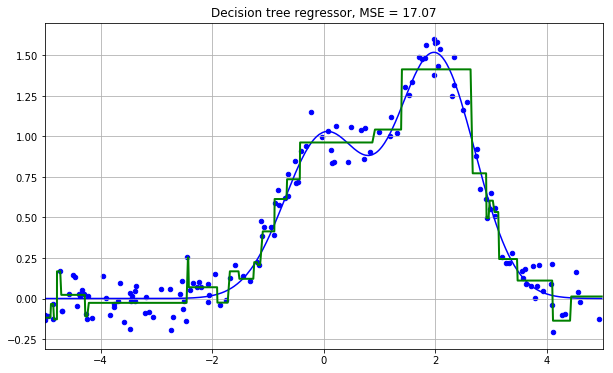

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(X_test, f(X_test), "b")
plt.scatter(X_train, y_train, c="b", s=20)
plt.plot(X_test, reg_tree_pred, "g", lw=2)
plt.xlim([-5, 5])
plt.title("Decision tree regressor, MSE = %.2f" % np.sum((y_test - reg_tree_pred) ** 2))
plt.grid()

Видим, что дерево решений аппроксимирует зависимость в данных кусочно-постоянной функцией. 

### Важность признаков в деревьях

Вместо того, чтобы просматривать все дерево, что может быть обременительно, есть некоторые полезные параметры, которые мы можем использовать как итоговые показатели работы дерева. Наиболее часто используемым показателем является важность признаков (feature importance), которая оценивает, насколько важен каждый признак с
94
точки зрения получения решений. Это число варьирует в диапазоне от 0 до 1 для каждого признака, где 0 означает «не используется вообще», а 1 означает, что «отлично предсказывает целевую переменную». Важности признаков в сумме всегда дают 1.

In [82]:
# Загрузим датасет для прогнозирования рака груди
cancer = sklearn.datasets.load_breast_cancer()
сX_train, сX_test, сy_train, сy_test = sklearn.model_selection.train_test_split(
  cancer.data, cancer.target, stratify=cancer.target, random_state=42
)
# Создадим классификатор, обучим и посмотрим насколько качественно он обучился
clf = sklearn.tree.DecisionTreeClassifier( max_depth = 4, random_state = 0 )
clf = clf.fit( сX_train, сy_train )

clf.score( сX_test, сy_test )

0.951048951048951

In [83]:
print("Важности признаков:")
print( clf.feature_importances_ )

Важности признаков:
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.01019737 0.04839825
 0.         0.         0.0024156  0.         0.         0.
 0.         0.         0.72682851 0.0458159  0.         0.
 0.0141577  0.         0.018188   0.1221132  0.01188548 0.        ]


In [84]:
for name, score in zip(cancer["feature_names"], clf.feature_importances_):
    print(name, ':', score)

mean radius : 0.0
mean texture : 0.0
mean perimeter : 0.0
mean area : 0.0
mean smoothness : 0.0
mean compactness : 0.0
mean concavity : 0.0
mean concave points : 0.0
mean symmetry : 0.0
mean fractal dimension : 0.0
radius error : 0.010197368202069328
texture error : 0.0483982536186494
perimeter error : 0.0
area error : 0.0
smoothness error : 0.002415595085315826
compactness error : 0.0
concavity error : 0.0
concave points error : 0.0
symmetry error : 0.0
fractal dimension error : 0.0
worst radius : 0.7268285094603201
worst texture : 0.045815897088866304
worst perimeter : 0.0
worst area : 0.0
worst smoothness : 0.014157702104714051
worst compactness : 0.0
worst concavity : 0.0181879968644502
worst concave points : 0.12211319926548449
worst symmetry : 0.01188547831013032
worst fractal dimension : 0.0


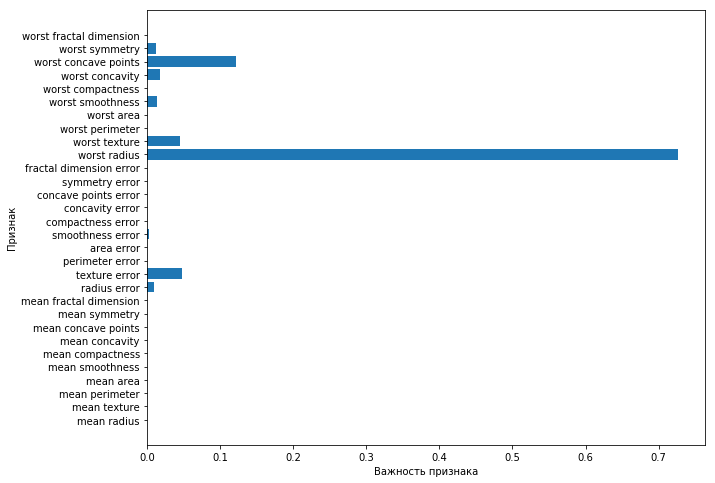

In [85]:
# Мы можем визуализировать важности признаков
def plot_feature_importances_cancer(model):
    n_features = cancer.data.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), cancer.feature_names)
    plt.xlabel("Важность признака")
    plt.ylabel("Признак")

plot_feature_importances_cancer( clf )

### Деревья решений и метод ближайших соседей в задаче прогнозирования оттока клиентов телеком-оператора

Считаем данные в DataFrame и проведем предобработку. Штаты пока сохраним в отдельный объект Series, но удалим из датафрейма. Первую модель будем обучать без штатов, потом посмотрим, помогают ли они. 

In [78]:
# https://raw.githubusercontent.com/Yorko/mlcourse.ai/master/data/telecom_churn.csv
df = pd.read_csv('/www/mlcourse.ai/data/telecom_churn.csv')    

In [79]:
df['International plan'] = pd.factorize(df['International plan'])[0]
df['Voice mail plan'] = pd.factorize(df['Voice mail plan'])[0]
df['Churn'] = df['Churn'].astype(int)
states = df['State']
y = df['Churn']
df.drop(['State', 'Churn'], axis=1, inplace=True)

In [80]:
df.head()

,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls
0,128,415,0,0,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,107,415,0,0,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1
2,137,415,0,1,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0
3,84,408,1,1,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2
4,75,415,1,1,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3


Выделим 70% выборки (X_train, y_train) под обучение и 30% будут отложенной выборкой (X_holdout, y_holdout). отложенная выборка никак не будет участвовать в настройке параметров моделей, на ней мы в конце, после этой настройки, оценим качество полученной модели.

In [81]:
X_train, X_holdout, y_train, y_holdout = sklearn.model_selection.train_test_split(
    df.values, y, test_size = 0.3, random_state = 17
)

Обучим 2 модели – дерево решений и kNN, пока не знаем, какие параметры хороши, поэтому наугад: глубину дерева берем 5, число ближайших соседей – 10.

In [44]:
tree = sklearn.tree.DecisionTreeClassifier( max_depth = 5, random_state = 17 )
knn = sklearn.neighbors.KNeighborsClassifier( n_neighbors = 10 )

In [45]:
%%time
tree.fit(X_train, y_train)

CPU times: user 15 ms, sys: 4.38 ms, total: 19.4 ms
Wall time: 15.9 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')

In [46]:
%%time
knn.fit(X_train, y_train)

CPU times: user 3.29 ms, sys: 2.53 ms, total: 5.82 ms
Wall time: 9.01 ms


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

Качество прогнозов будем проверять с помощью простой метрики – доли правильных ответов.

In [49]:
from sklearn.metrics import accuracy_score

tree_pred = tree.predict( X_holdout )
accuracy_score( y_holdout, tree_pred )

0.94

In [50]:
knn_pred = knn.predict(X_holdout)
accuracy_score(y_holdout, knn_pred)

0.881

Теперь настроим параметры дерева на кросс-валидации. Настраивать будем максимальную глубину и максимальное используемое на каждом разбиении число признаков. Суть того, как работает GridSearchCV: для каждой уникальной пары значений  параметров `max_depth` и `max_features` будет проведена 5-кратная кросс-валидация и выберется лучшее сочетание параметров.

#### Подбор гиперпараметров моделей, GridSearchCV

In [53]:
tree_params = {
    'max_depth': range(1,11),
    'max_features': range(4,19)
}

tree_grid = sklearn.model_selection.GridSearchCV(
    tree, tree_params,
    cv = 5, n_jobs = -1,
    verbose = True
)

tree_grid.fit( X_train, y_train )

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    2.5s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': range(1, 11), 'max_features': range(4, 19)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=True)

Лучшее сочетание параметров и соответствующая средняя доля правильных ответов на кросс-валидации:

In [54]:
tree_grid.best_params_

{'max_depth': 6, 'max_features': 17}

In [55]:
tree_grid.best_score_

0.9425632233176168

In [56]:
accuracy_score( y_holdout, tree_grid.predict( X_holdout ) )

0.946

Теперь попробуем настроить число соседей в алгоритме kNN.
Заодно ознакомимся с конвеерами (Pipeline) и трансформаторами данных (sklearn.preprocessing.StandardScale)

In [59]:
# Pipeline предоставляет интерфейс для нескольких шагов преобразования данных и итоговой оценки.
# Он инкапсулирует трансформаторы и предиктор внутри
import sklearn.pipeline
# StandardScaler преобразует признак так, что еге распределение будет иметь
# среднее значение 0 и стандартное отклонение 1.
import sklearn.preprocessing

knn_pipe = sklearn.pipeline.Pipeline([
    ('scaler', sklearn.preprocessing.StandardScaler()),
    ('knn', sklearn.neighbors.KNeighborsClassifier(n_jobs=-1))
])

In [61]:
knn_params = { 'knn__n_neighbors': range(1, 10) }

knn_grid = sklearn.model_selection.GridSearchCV(
    knn_pipe, knn_params, cv = 5, n_jobs = -1, verbose = True
)

knn_grid.fit( X_train, y_train )

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    3.6s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'knn__n_neighbors': range(1, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=True)

In [62]:
knn_grid.best_params_, knn_grid.best_score_

({'knn__n_neighbors': 7}, 0.8859837119588513)

In [63]:
accuracy_score( y_holdout, knn_grid.predict(X_holdout) )

0.89

## Ансамбли деревьев решений

*Ансамбли* (*ensembles*) – это методы, которые сочетают в себе множество моделей машинного обучения, чтобы в итоге получить более качественную модель. Существует множество моделей машинного обучения, которые принадлежат к этой категории, но есть две ансамблевых модели, которые доказали свою эффективность на самых различных наборах данных для задач классификации и регрессии, обе используют деревья решений в качестве строительных блоков: *случайный лес деревьев решений* и *градиентный бустинг деревьев решений*.

### Случайный лес

Как мы только что отметили, основным недостатком деревьев решений является их склонность к переобучению. Случайный лес является одним из способов решения этой проблемы. По сути случайный лес – это набор деревьев решений, где каждое дерево немного отличается от остальных. Идея случайного леса заключается в том, что каждое дерево может довольно хорошо прогнозировать, но скорее всего переобучается на части данных. Если мы построим много деревьев, которые хорошо работают и переобучаются с разной степенью, мы можем уменьшить переобучение путем усреднения их результатов.

Случайные леса получили свое название из-за того, что в процесс построения деревьев была внесена случайность, призванная обеспечить уникальность каждого дерева.

Существует две техники, позволяющие получить рандомизированные деревья в рамках случайного леса:
- сначала выбираем точки данных (наблюдения), которые будут использоваться для построения дерева,
- затем отбираем признаки в каждом разбиении.

#### sklearn.ensemble.RandomForestClassifier (RandomForestRegressor)

Параметр `n_estimators` — количество деревьев. Эти деревья будут построены совершенно независимо друг от друга, и алгоритм будет случайным образом отбирать признаки для построения каждого дерева, чтобы получить непохожие друг на друга деревья.

Параметр `max_features` — максимальное количество признаков для каждого дерева. Высокое значение `max_features` означает, что деревья в случайном лесе будут весьма схожи между собой и они смогут легко аппроксимировать данные, используя наиболее дискриминирующие признаки. Низкое значение `max_features` означает, что деревья в случайном лесе будут сильно отличаться друг от друга и, возможно, каждое дерево будет иметь очень большую глубину, чтобы хорошо соответствовать данным.

Чтобы дать прогноз для случайного леса, алгоритм сначала дает прогноз для каждого дерева в лесе. Для регрессии мы можем усреднить эти результаты, чтобы получить наш окончательный прогноз. Для классификации используется стратегия «мягкого голосования». Это означает, что каждый алгоритм дает «мягкий» прогноз, вычисляя вероятности для каждого класса. Эти вероятности усредняются по всем деревьям и прогнозируется класс с наибольшей вероятностью.

Границы принятия решений, найденные пятью рандомизированными деревьями решений, и граница принятия решений, полученная путем усреднения их спрогнозированных вероятностей:

![random-forest-example](https://bitbucket.org/despairr/ds-course-2018/raw/dbbafa803be8b1f01cc078ba3ba96d176b220669/intro-to-ml-images/365.png)

#### Пример применения случайного леса к задаче с уходом клиентов телеком-оператора

In [74]:
import sklearn.ensemble

forest = sklearn.ensemble.RandomForestClassifier( n_estimators=100, n_jobs=-1, random_state=17 )

np.mean( sklearn.model_selection.cross_val_score(forest, X_train, y_train, cv=5) )

0.9578105660869

In [87]:
# Поищем наилучшие параметры для случайного леса с помощью GridSearchCV

forest_params = {
    'max_depth': range(1,11),
    'max_features': range(4,19)
}

forest_grid = sklearn.model_selection.GridSearchCV(
    forest, forest_params, cv = 5, n_jobs = -1, verbose = True
)

forest_grid.fit( X_train, y_train )

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:  3.1min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=17, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': range(1, 11), 'max_features': range(4, 19)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=True)

In [88]:
forest_grid.best_params_, forest_grid.best_score_

({'max_depth': 9, 'max_features': 6}, 0.9511358765537934)

In [89]:
accuracy_score( y_holdout, forest_grid.predict(X_holdout) )

0.953

## Плюсы и минусы деревьев решений

**Плюсы:**
 - Порождение четких правил классификации, понятных человеку, например, "если возраст < 25 и интерес к мотоциклам, то отказать в кредите". Это свойство называют интерпретируемостью модели;
 - Деревья решений могут легко визуализироваться, то есть может "интерпретироваться" (строгого определения я не видел) как сама модель (дерево), так и прогноз для отдельного взятого тестового объекта (путь в дереве);
 - Быстрые процессы обучения и прогнозирования;
 - Малое число параметров модели;
 - Поддержка и числовых, и категориальных признаков. Однако в sklearn напрямую категориальные признаки не поддержэиваются, их нужно перекодировать в набор бинарных признаков (one-hot-encoding): см. пример ниже.
 
**Минусы:**
 - У порождения четких правил классификации есть и другая сторона: деревья очень чувствительны к шумам во входных данных, вся модель может кардинально измениться, если немного изменится обучающая выборка (например, если убрать один из признаков или добавить несколько объектов), поэтому и правила классификации могут сильно изменяться, что ухудшает интерпретируемость модели;
 - Разделяющая граница, построенная деревом решений, имеет свои ограничения (состоит из гиперплоскостей, перпендикулярных какой-то из координатной оси), и на практике дерево решений по качеству классификации уступает некоторым другим методам;
 - Необходимость отсекать ветви дерева (pruning) или устанавливать минимальное число элементов в листьях дерева или максимальную глубину дерева для борьбы с переобучением. Впрочем, переобучение - проблема всех методов машинного обучения;
 - Нестабильность. Небольшие изменения в данных могут существенно изменять построенное дерево решений. С этой проблемой борются с помощью ансамблей деревьев решений (рассмотрим далее);
 - Проблема поиска оптимального дерева решений (минимального по размеру и способного без ошибок классифицировать выборку) NP-полна, поэтому на практике используются эвристики типа жадного поиска признака с максимальным приростом информации, которые не гарантируют нахождения глобально оптимального дерева;
 - Модель умеет только интерполировать, но не  экстраполировать (это же верно и для леса и бустинга на деревьях). То есть дерево решений делает константный прогноз для объектов, находящихся в признаковом пространстве вне параллелепипеда, охватывающего все объекты обучающей выборки. В нашем примере с желтыми и синими шариками это значит, что модель дает одинаковый прогноз для всех шариков с координатой > 19 или < 0.

### Плюсы и минусы метода ближайших соседей

Плюсы:
 - Простая реализация
 - Неплохая интерпретация, можно объяснить, почему тестовый пример был классифицирован именно так. Хотя этот аргумент можно атаковать: если число соседей большое, то интерпретация ухудшается (условно: "мы не дали ему кредит, потому что он похож на 350 клиентов, из которых 70 – плохие, что на 12% больше, чем в среднем по выборке").
 
Минусы:
 - Метод считается быстрым в сравнении, например, с композициями алгоритмов, но в реальных задачах, как правило, число соседей, используемых для классификации, будет большим (100-150), и в таком случае алгоритм будет работать не так быстро, как дерево решений;
 - Если в наборе данных много признаков, то трудно подобрать подходящие веса и определить, какие признаки не важны для классификации/регрессии;
 - Зависимость от выбранной метрики расстояния между примерами. Выбор по умолчанию евклидового расстояния чаще всего ничем не обоснован. Можно отыскать хорошее решение перебором параметров, но для большого набора данных это отнимает много времени;
 - В случае малого числа соседей метод чувствителен к выбросам, то есть склонен переобучаться;
 - Как правило, плохо работает, когда признаков много, из-за "прояклятия размерности"

In [90]:
# пример one-hot-encoding

data = pd.DataFrame()
data['A'] = ['a','a','b','a']
data['B'] = ['b','b','a','b']
data['C'] = [0, 0, 1, 0]
data['Class'] = ['n','n','y','n']

tree = sklearn.tree.DecisionTreeClassifier()

one_hot_data = pd.get_dummies(data[['A','B','C']],drop_first=True)
tree.fit(one_hot_data, data['Class'])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [93]:
# factorize – перевод строковых категориальных признаков в целочисленные
cat = pd.Series(['a', 'a', 'c'])
labels, uniques = pd.factorize(cat)
list(labels), list(uniques)

([0, 0, 1], ['a', 'c'])